In [2]:
# get needed modules

import numpy as np
from magic import movie
import os
import matplotlib

from netCDF4 import Dataset, date2num, num2date
from datetime import datetime, timedelta

import cartopy
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile

# for showing plots inside notebook
%matplotlib inline 

In [3]:
# Get magic data
data_path = '/media/rakesh/Seagate Expansion Drive/Data2/Polar_vortex_runs/Eta0.8/Ek1e-4/eta_0.8_Pr1e-1_Ra7e6'

U_filename = "Vp_R=C4_mov.tag_a" # Zonal
V_filename = "Vt_R=C3_mov.tag_a" # Meridional

os.chdir(data_path)
U_frames =  movie.Movie(file=U_filename, iplot=False)
V_frames =  movie.Movie(file=V_filename, iplot=False)

nframes = U_frames.nvar
print('Data has {} frames, {} points in lat, and {} points in lon.'.format(U_frames.nvar, 
                                                                           int(U_frames.n_phi_tot/2), 
                                                                           U_frames.n_phi_tot))

Data has 240 frames, 480 points in lat, and 960 points in lon.


In [6]:
# function for creating netCDF files using MagIC data

def makeCDF(ncout, hrs, lats, lons, udata, vdata):
        
    # define axis size
    ncout.createDimension('time', 1)  
    ncout.createDimension('lat', len(lats))
    ncout.createDimension('lon', len(lons))

    
    # create longitude axis
    longitude = ncout.createVariable('Longitude', 'float32', 'lon')
    #longitude.standard_name = 'longitude'
    #longitude.long_name = 'longitude'
    longitude.units = 'degrees east'
    #lon.axis = 'X'
    
    # create latitude axis
    latitude = ncout.createVariable('Latitude', 'float32', 'lat')
    #latitude.standard_name = 'latitude'
    #latitude.long_name = 'latitude'
    latitude.units = 'degrees north'
    #lat.axis = 'Y'
    
    # create time axis
    time = ncout.createVariable('time', 'float32', ('time',))
    #time.long_name = 'time'
    time.units = 'hours since 1987-03-30'
    #time.calendar = 'standard'
    #time.axis = 'T'

    
    # create variable array
    uout = ncout.createVariable('U', 'float32', ('time', 'lat', 'lon'))
    #uout.long_name = 'zon'
    uout.units = 'Rey'

    # create variable array
    vout = ncout.createVariable('V', 'float32', ('time', 'lat', 'lon'))
    #vout.long_name = 'mer'
    vout.units = 'Rey'
    
    
    uout[:,:,:] = np.reshape(udata.T, (1,len(lats),len(lons)))
    vout[:,:,:] = np.reshape(vdata.T, (1,len(lats),len(lons)))

 
    latitude[:] = lats
    longitude[:] = lons
 
    hrs = timedelta(hours=hrs) # time passed in DD:HH:MM:SS
    date = datetime(1987,3,30) + hrs # add time passed to the starting date
    
    time[:] = date2num(date, time.units)
    print('File written for:', time[:], time.units)

    
nlats=int(U_frames.n_phi_tot/2)
nlons=int(U_frames.n_phi_tot)
ntimes=1
num_files = 25

lats =  np.linspace(-90, 90, nlats, dtype=np.float32) # south pole to north pole
lons =  np.linspace(-180, 180, nlons, dtype=np.float32) # Greenwich meridian eastward

# Location where .nc files will be saved
os.chdir('/home/rakesh/Desktop/Particle_tracing/magic_CDF_files')

for i in range(0,num_files):
    ncout = Dataset('UV_frame_{:02d}.nc'.format(i), 'w', format='NETCDF4')
    makeCDF(ncout, i, lats, lons, 
                     U_frames.data[0,i,:,:], 
                     V_frames.data[0,i,:,:])
    ncout.close();del ncout # close file



File written for: [0.] hours since 1987-03-30
File written for: [1.] hours since 1987-03-30
File written for: [2.] hours since 1987-03-30
File written for: [3.] hours since 1987-03-30
File written for: [4.] hours since 1987-03-30
File written for: [5.] hours since 1987-03-30
File written for: [6.] hours since 1987-03-30
File written for: [7.] hours since 1987-03-30
File written for: [8.] hours since 1987-03-30
File written for: [9.] hours since 1987-03-30
File written for: [10.] hours since 1987-03-30
File written for: [11.] hours since 1987-03-30
File written for: [12.] hours since 1987-03-30
File written for: [13.] hours since 1987-03-30
File written for: [14.] hours since 1987-03-30
File written for: [15.] hours since 1987-03-30
File written for: [16.] hours since 1987-03-30
File written for: [17.] hours since 1987-03-30
File written for: [18.] hours since 1987-03-30
File written for: [19.] hours since 1987-03-30
File written for: [20.] hours since 1987-03-30
File written for: [21.]

In [7]:
# Location of stored .nc files
os.chdir('/home/rakesh/Desktop/Particle_tracing')


filenames = {'U': "magic_CDF_files/UV_frame_*.nc",
             'V': "magic_CDF_files/UV_frame_*.nc"}

variables = {'U': 'U',
             'V': 'V'}

dimensions = {'lat': 'Latitude',
              'lon': 'Longitude', 
              'time': 'time'}

fieldset = FieldSet.from_netcdf(filenames, 
                                variables, 
                                dimensions,
                               allow_time_extrapolation=True)

# for allowing periodicity in zonal direction
fieldset.add_constant('halo_west', fieldset.U.grid.lon[0])
fieldset.add_constant('halo_east', fieldset.U.grid.lon[-1])
fieldset.add_periodic_halo(zonal=True)

# get the starting time in a file
print(fieldset.U.grid.time_origin) 

# get the time in file(s); for one file this will be zero
# for a bunch, this will give the time in seconds of all the files
# starting from zero for first file.

print(fieldset.U.grid.time) # in seconds



1987-03-30T00:00:00.000000000
[    0.  3600.  7200. 10800. 14400. 18000. 21600. 25200. 28800. 32400.
 36000. 39600. 43200. 46800. 50400. 54000. 57600. 61200. 64800. 68400.
 72000. 75600. 79200. 82800. 86400.]


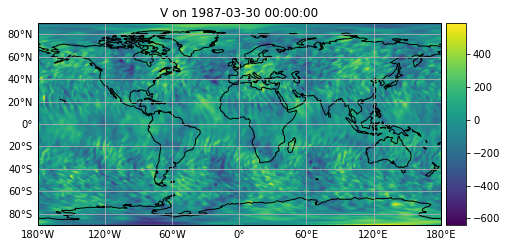

In [8]:

matplotlib.rcParams['figure.figsize'] = (7.0, 7.0)

# after importing cartopy
# use the following to give projection type: 
#    projection=cartopy.crs.Mollweide()
# or projection=cartopy.crs.Orthographic()

#fieldset.U.show(land=True, projection=cartopy.crs.Orthographic(central_latitude=45))
fieldset.V.show(land=True)

In [11]:
num_particles=20
pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
                             lon=np.zeros(num_particles)+0, # a vector of release longitudes 
                             lat=np.linspace(-70,70,num=num_particles))    # a vector of release latitudes

#print(pset)

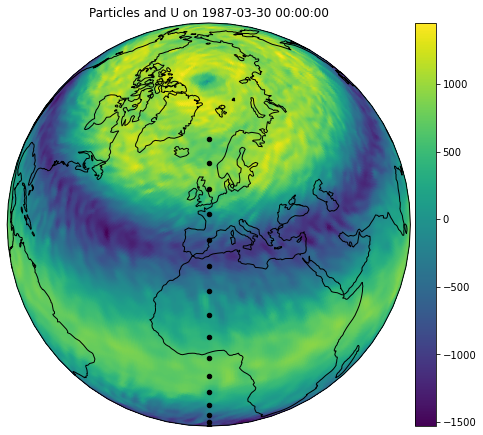

In [12]:
pset.show(field=fieldset.U, projection=cartopy.crs.Orthographic(central_latitude=45))

In [13]:
# OceanParcels function for allowing peridiocity in zonal cirection
def periodicBC(particle, fieldset, time):
    if particle.lon < fieldset.halo_west:
        particle.lon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle.lon -= fieldset.halo_east - fieldset.halo_west


output_file = pset.ParticleFile(name='NestedFieldParticle.nc', 
                                outputdt=500
                               )
pset.execute(AdvectionRK4+ pset.Kernel(periodicBC), 
             runtime=timedelta(hours=20),    # the total length of the run
             dt=timedelta(minutes=60),      # the timestep of the kernel
             output_file = output_file)

output_file.export()

INFO: Compiled JITParticleAdvectionRK4periodicBC ==> /tmp/parcels-1000/dd7dbd9c04e04b00d9e37afab2eba20d_0.so


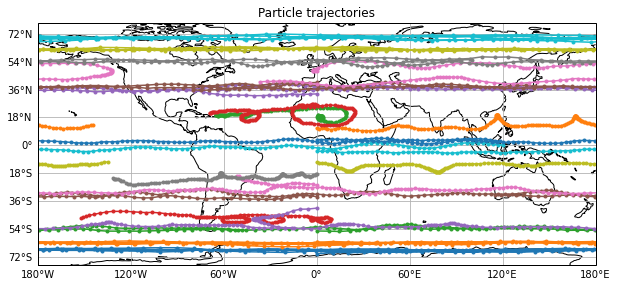

<module 'matplotlib.pyplot' from '/home/rakesh/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [14]:
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)


#plotTrajectoriesFile('NestedFieldParticle.nc', mode='movie2d_notebook')
plotTrajectoriesFile('NestedFieldParticle.nc', mode='2d')